# Visualization

This script visualizes the trajectory of the drone by combining different libraries.

The script offers a comprehensive visualization of the drone's flight by generating plots for LLH and velocity in fonction of time

Package requirements:
- Numpy.
- Pandas.
- Folium.
- Matplotlib.
- GEE python API.


## Importing packages

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import folium
import ee
from ee import image
from folium import plugins
%matplotlib widget

## Authenticate and initialize for GEE

In [2]:
ee.Initialize()
# ee.Authenticate() #Just for the 1st time

## Ploting trajectory of the UAV

In [3]:
#Specify the path of the data
file_path='C:/Users/bourriz/GNSS_INS_Processing/UIS_PosPac_HyspexNav_processing/Result/Position/gnss_data.csv'
df=pd.read_csv(file_path,sep=',')
display(df.head(5))

,GPST,Timestamp,UTC_Time,Latitude,Longitude,Height,Q,ns,sdn(m),sde(m),...,ratio,vn(m/s),ve(m/s),vu(m/s),sdvn,sdve,sdvu,sdvne,sdveu,sdvun
0,2186,466543.4,2021-12-03 09:35:25,-21.241363,14.876887,901.7170,4,3,4.0148,7.7656,...,1.4,-1.03204,1.91748,0.08522,2.26644,3.64198,10.23567,-2.12832,-5.63846,4.05694
1,2186,466543.6,2021-12-03 09:35:25,-21.241365,14.876892,901.7332,4,3,3.7037,7.1768,...,1.4,-0.33353,0.53270,0.02729,2.10978,3.38555,9.78956,-2.09458,-5.39471,3.87928
2,2186,466544.2,2021-12-03 09:35:26,-21.241366,14.876893,901.7352,4,3,2.9174,5.6605,...,1.4,0.01021,-0.04879,0.00073,1.38262,2.62462,8.48690,-1.85061,-4.68343,3.36569
3,2186,466544.4,2021-12-03 09:35:26,-21.241366,14.876893,901.7354,4,3,2.6713,5.1838,...,1.4,0.02707,-0.00883,0.00085,1.31835,2.49828,8.06588,-1.75813,-4.45124,3.19850
4,2186,466544.6,2021-12-03 09:35:26,-21.241366,14.876893,901.7355,4,3,2.4379,4.7316,...,1.4,-0.00599,0.04072,0.00218,1.25539,2.37423,7.65196,-1.66718,-4.22295,3.03414


In [4]:
# Assigning values to variables
Timestamp=df['Timestamp']
longitude=df['Longitude']
latitude=df['Latitude']
height=df['Height']
sat=df['ns']
sdn=df['sdn(m)']
sde=df['sde(m)']
sdu=df['sdu(m)']
vn=df['vn(m/s)']
ve=df['ve(m/s)']
vu=df['vu(m/s)']

[]

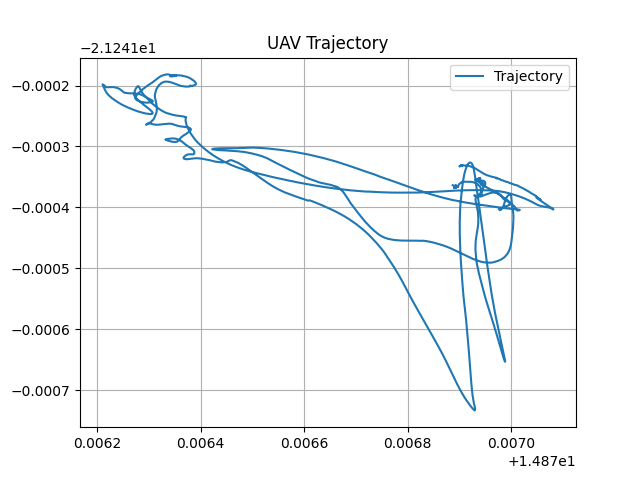

In [5]:
#Plot 
fig,ax=plt.subplots()
ax.plot(longitude.values,latitude.values,label='Trajectory')
ax.set_title('UAV Trajectory')
ax.legend()
ax.axis(True)
ax.grid()
ax.plot()

In [6]:
df.Latitude.mean()

-21.241357190012717

In [7]:
#Using a basemap
aoi = ee.Geometry.Point([df.Latitude.mean(),df.Longitude.mean()]).buffer(5000) #Get the region of interest

In [8]:
# ##### Define a method for displaying Earth Engine image tiles to folium map
def add_ee_layer(self, ee_image_object, vis_params, name):
  map_id_dict = ee.Image(ee_image_object).getMapId(vis_params)
  layer = folium.raster_layers.TileLayer(
      tiles = map_id_dict['tile_fetcher'].url_format,
      attr = 'Map Data &copy; <a href="https://earthengine.google.com/">Google Earth Engine</a>',
      name = name,
      overlay = True,
      control = True
  )
  layer.add_to(self)
  return layer
folium.Map.add_ee_layer = add_ee_layer

In [9]:
# Define the image,the visualization parameters (in this case we use Sentinel 2)

sentinel = ee.Image('COPERNICUS/S2_SR_HARMONIZED/20230109T085331_20230109T090948_T33KVS')
image_params = {
  'bands': ['B4',  'B3',  'B2'],
  'min': 663.9231963644881,
  'max': 3123.470688347291,
  'gamma': 1.21,
  'opacity':1
}

In [10]:
#Define the basemap
basemaps={
      'Google Satellite': folium.TileLayer(
        tiles = 'https://mt1.google.com/vt/lyrs=s&x={x}&y={y}&z={z}',
        attr = 'Google',
        name = 'Google Satellite',
        overlay = True,
        control = True
    )
}

In [11]:
mymap = folium.Map( location=[ df.Latitude.mean(), df.Longitude.mean()],zoom_start=16)
basemaps['Google Satellite'].add_to(mymap)
image_sat_layer = mymap.add_ee_layer(sentinel, image_params, 'Sentinel 2')
mymap.add_child(folium.LayerControl())

In [12]:
#Add the trajectory of the drone
points=[]
points.append(df[['Latitude','Longitude']].values)
for coord in points:
    folium.PolyLine(points,color='red',weight=2.5).add_to(mymap)
mymap